[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/utkarshp1161/Active-learning-in-microscopy/blob/main/notebooks/1_BI-noGP.ipynb)

# Least Squares vs Bayesian Inference: Scalable Implementation (PyTorch/Pyro)

- Written by [Utkarsh Pratiush](https://github.com/utkarshp1161)

**Tutorial Goals:**
- Use a 2-Gaussian peaks function as the ground truth.
- Compare Least Squares (LS) and Bayesian Inference (BI) for parameter estimation.
- Visualize fits, uncertainty, and residuals.
- Compare with more strucutre/prioys


In [ ]:
!pip install pyro-ppl==1.9.1

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from torch.optim import Adam
torch.manual_seed(0)
np.random.seed(0)

## 1. Define Ground Truth: 2-Gaussian Peaks

We use a function with two Gaussian peaks as our ground truth. This is common in spectroscopy and other scientific applications.

In [9]:
def two_gaussian_peaks(x, amp1, cen1, wid1, amp2, cen2, wid2, baseline):
    """Sum of two Gaussian peaks plus a baseline."""
    return (amp1 * torch.exp(-0.5 * ((x - cen1) / wid1) ** 2) +
            amp2 * torch.exp(-0.5 * ((x - cen2) / wid2) ** 2) +
            baseline)

## 2. Generate Synthetic Data

We generate noisy measurements from the ground truth function.

In [10]:
# True parameters for 2-Gaussian peaks
true_params = {
    'amp1': 3.0, 'cen1': 2.0, 'wid1': 0.5,
    'amp2': 2.0, 'cen2': 6.0, 'wid2': 0.8,
    'baseline': 0.1
}
x = torch.linspace(0, 8, 50)
y_true = two_gaussian_peaks(x, **true_params)
noise_std = 0.15
y_obs = y_true + noise_std * torch.randn_like(x)

### Plot: Ground Truth and Noisy Data

Visualize the true function and noisy observations.

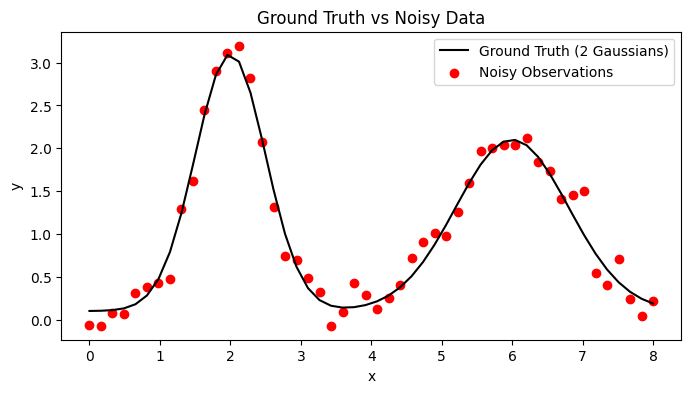

In [11]:
plt.figure(figsize=(8,4))
plt.plot(x, y_true, 'k-', label='Ground Truth (2 Gaussians)')
plt.scatter(x, y_obs, color='red', label='Noisy Observations')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ground Truth vs Noisy Data')
plt.legend()
plt.show()

## 3. Least Squares Fit (PyTorch)

We fit the sum of two Gaussians using least squares optimization.

In [12]:
def ls_model(x, params):
    amp1, cen1, wid1, amp2, cen2, wid2, baseline = params
    return two_gaussian_peaks(x, amp1, cen1, wid1, amp2, cen2, wid2, baseline)

# Initial guess
init_params = torch.tensor([2.5, 1.5, 0.6, 1.5, 5.5, 1.0, 0.0], requires_grad=True)
optimizer = Adam([init_params], lr=0.05)

def ls_loss(params):
    y_pred = ls_model(x, params)
    return torch.mean((y_pred - y_obs) ** 2)

for i in range(800):
    optimizer.zero_grad()
    loss = ls_loss(init_params)
    loss.backward()
    optimizer.step()
ls_fit = init_params.detach().clone()
print("LS Fit Params:", ls_fit.tolist())

LS Fit Params: [3.1275570392608643, 2.0041329860687256, 0.47229060530662537, 2.010528802871704, 5.99959659576416, 0.8449891805648804, 0.08528351783752441]


### Plot: LS Fit vs Data

Compare the least squares fit to the data and ground truth.

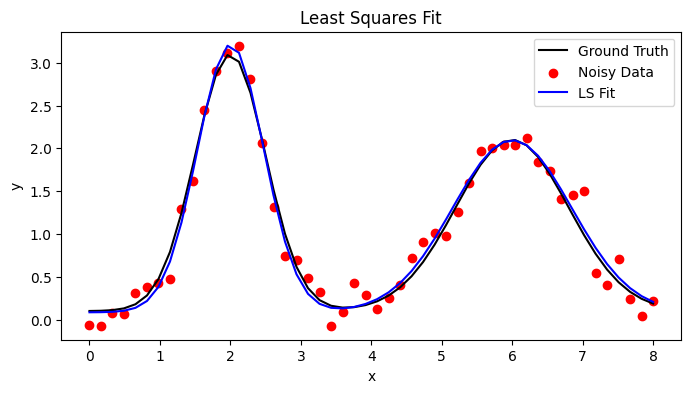

In [13]:
y_ls = ls_model(x, ls_fit)
plt.figure(figsize=(8,4))
plt.plot(x, y_true, 'k-', label='Ground Truth')
plt.scatter(x, y_obs, color='red', label='Noisy Data')
plt.plot(x, y_ls, 'b-', label='LS Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Least Squares Fit')
plt.legend()
plt.show()

### Plot: LS Residuals

Visualize the residuals (difference between fit and data).

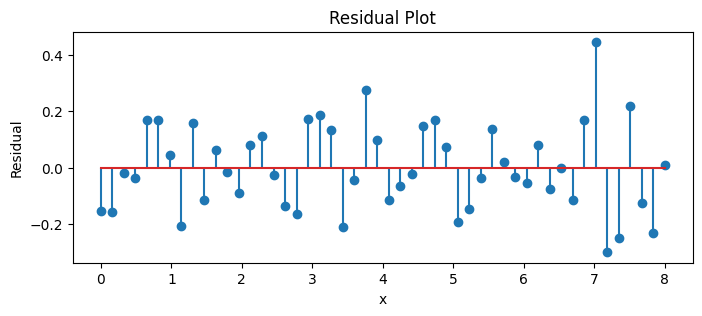

In [16]:
import matplotlib.pyplot as plt

# Ensure x, y_obs, y_ls are NumPy arrays
x_np = x.detach().cpu().numpy() if hasattr(x, 'detach') else x
y_obs_np = y_obs.detach().cpu().numpy() if hasattr(y_obs, 'detach') else y_obs
y_ls_np = y_ls.detach().cpu().numpy() if hasattr(y_ls, 'detach') else y_ls

plt.figure(figsize=(8, 3))
plt.stem(x_np, y_obs_np - y_ls_np)
plt.xlabel('x')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()


## 4. Bayesian Inference (Pyro MCMC)

We use Pyro to perform Bayesian inference, estimating the full posterior over parameters.

In [17]:
def model(x, y_obs=None):
    amp1 = pyro.sample("amp1", dist.Normal(2.5, 2.0))
    cen1 = pyro.sample("cen1", dist.Normal(2.0, 1.0))
    wid1 = pyro.sample("wid1", dist.HalfCauchy(0.5))
    amp2 = pyro.sample("amp2", dist.Normal(2.0, 2.0))
    cen2 = pyro.sample("cen2", dist.Normal(6.0, 1.0))
    wid2 = pyro.sample("wid2", dist.HalfCauchy(0.5))
    baseline = pyro.sample("baseline", dist.HalfCauchy(0.2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(0.2))
    y_mean = two_gaussian_peaks(x, amp1, cen1, wid1, amp2, cen2, wid2, baseline)
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(y_mean, sigma), obs=y_obs)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=600, warmup_steps=300, num_chains=1)
mcmc.run(x, y_obs)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 900/900 [01:05, 13.78it/s, step size=2.01e-01, acc. prob=0.932]


### Plot: Posterior Parameter Distributions

Visualize the marginal posterior distributions for each parameter.

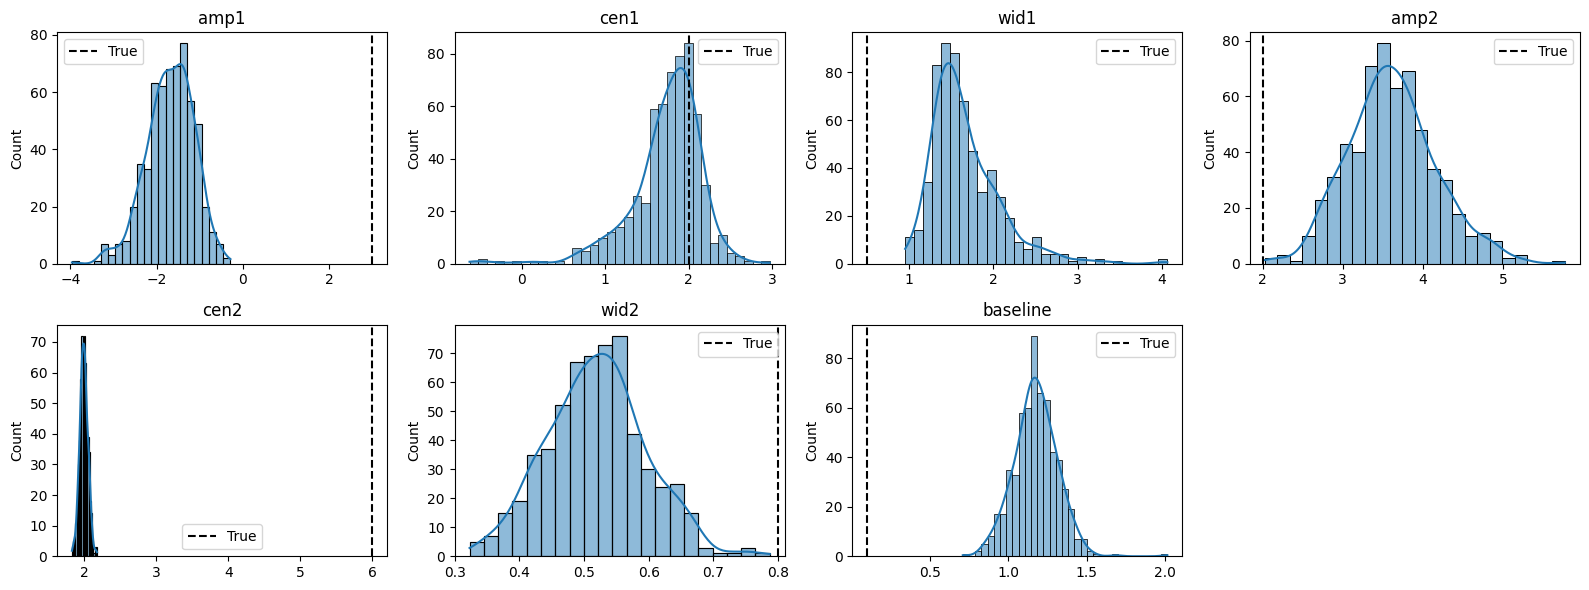

In [18]:
import seaborn as sns
params_list = ["amp1", "cen1", "wid1", "amp2", "cen2", "wid2", "baseline"]
fig, axs = plt.subplots(2, 4, figsize=(16,6))
for i, p in enumerate(params_list):
    ax = axs.flat[i]
    sns.histplot(posterior_samples[p].numpy(), ax=ax, kde=True)
    ax.axvline(true_params[p], color='k', linestyle='--', label="True")
    ax.set_title(p)
    ax.legend()
axs.flat[-1].axis('off')
plt.tight_layout()
plt.show()

## 5. Bayesian Posterior Predictive Fit

Draw samples from the posterior predictive and visualize uncertainty.

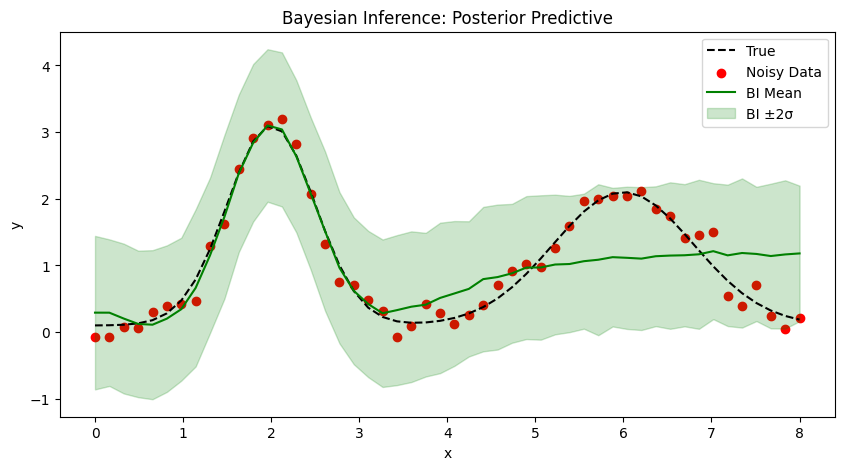

In [19]:
predictive = Predictive(model, posterior_samples, return_sites=["amp1", "cen1", "wid1", "amp2", "cen2", "wid2", "baseline", "sigma", "obs"])
samples = predictive(x)
y_bi_mean = samples["obs"].mean(0)
y_bi_std = samples["obs"].std(0)

plt.figure(figsize=(10,5))
plt.plot(x, y_true, 'k--', label="True")
plt.scatter(x, y_obs, color='red', label="Noisy Data")
plt.plot(x, y_bi_mean, 'g-', label="BI Mean")
plt.fill_between(x, y_bi_mean - 2*y_bi_std, y_bi_mean + 2*y_bi_std, color='green', alpha=0.2, label="BI ±2σ")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Bayesian Inference: Posterior Predictive")
plt.legend()
plt.show()

### Plot: BI Residuals

Visualize the residuals for the Bayesian fit.

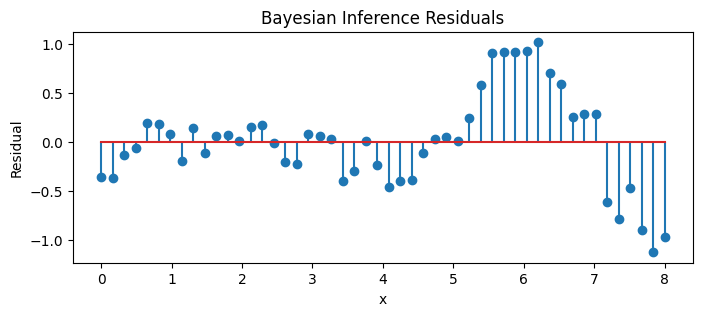

In [25]:
import matplotlib.pyplot as plt

def to_numpy(t):
    return t.detach().cpu().numpy() if hasattr(t, 'detach') else t

# Convert all to numpy arrays
x_np = to_numpy(x)
y_obs_np = to_numpy(y_obs)
y_bi_mean_np = to_numpy(y_bi_mean)

# Plot residuals
plt.figure(figsize=(8, 3))
plt.stem(x_np, y_obs_np - y_bi_mean_np)
plt.xlabel('x')
plt.ylabel('Residual')
plt.title('Bayesian Inference Residuals')
plt.show()


## 6. Summary Table: LS vs BI

Compare true parameters, LS fit, and BI posterior mean and std.

In [26]:
print("Parameter   True     LS Fit    BI Mean    BI Std")
for i, p in enumerate(params_list):
    ls_val = ls_fit[i].item()
    bi_mean = posterior_samples[p].mean().item()
    bi_std = posterior_samples[p].std().item()
    print(f"{p:8s} {true_params[p]:7.3f} {ls_val:9.3f} {bi_mean:9.3f} {bi_std:9.3f}")

Parameter   True     LS Fit    BI Mean    BI Std
amp1       3.000     3.128    -1.682     0.543
cen1       2.000     2.004     1.738     0.426
wid1       0.500     0.472     1.664     0.412
amp2       2.000     2.011     3.615     0.550
cen2       6.000     6.000     1.994     0.057
wid2       0.800     0.845     0.519     0.076
baseline   0.100     0.085     1.175     0.139


## 7. Discussion

- **LS** gives point estimates, but no uncertainty.
- **BI** provides full parameter distributions and predictive uncertainty.
- **BI** can reveal parameter correlations and multimodality.
- Both methods recover the true function well, but BI gives richer information.
- This approach is scalable and fast using PyTorch/Pyro.

**Try changing the noise level, number of data points, or priors to see how inference changes!**

## 8. Bayesian Model Comparison: Multiple Priors/Structures

We now illustrate how to use multiple candidate functions as priors/structures for Bayesian inference, and compare their performance on the same data.

We will try:
- Two-Gaussian peaks (correct structure)
- Single Gaussian (underspecified)
- Polynomial (wrong structure)

In [27]:
# Define candidate model structures
def two_gaussian_model(x, y_obs=None):
    amp1 = pyro.sample("amp1", dist.Normal(2.5, 2.0))
    cen1 = pyro.sample("cen1", dist.Normal(2.0, 1.0))
    wid1 = pyro.sample("wid1", dist.HalfCauchy(0.5))
    amp2 = pyro.sample("amp2", dist.Normal(2.0, 2.0))
    cen2 = pyro.sample("cen2", dist.Normal(6.0, 1.0))
    wid2 = pyro.sample("wid2", dist.HalfCauchy(0.5))
    baseline = pyro.sample("baseline", dist.HalfCauchy(0.2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(0.2))
    y_mean = two_gaussian_peaks(x, amp1, cen1, wid1, amp2, cen2, wid2, baseline)
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(y_mean, sigma), obs=y_obs)

def single_gaussian(x, amp, cen, wid, baseline):
    return amp * torch.exp(-0.5 * ((x - cen) / wid) ** 2) + baseline

def single_gaussian_model(x, y_obs=None):
    amp = pyro.sample("amp", dist.Normal(2.5, 2.0))
    cen = pyro.sample("cen", dist.Normal(4.0, 2.0))
    wid = pyro.sample("wid", dist.HalfCauchy(0.5))
    baseline = pyro.sample("baseline", dist.HalfCauchy(0.2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(0.2))
    y_mean = single_gaussian(x, amp, cen, wid, baseline)
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(y_mean, sigma), obs=y_obs)

def poly4(x, a4, a3, a2, a1, a0):
    return a4*x**4 + a3*x**3 + a2*x**2 + a1*x + a0

def poly4_model(x, y_obs=None):
    a4 = pyro.sample("a4", dist.Normal(0.0, 0.1))
    a3 = pyro.sample("a3", dist.Normal(0.0, 0.1))
    a2 = pyro.sample("a2", dist.Normal(0.0, 0.5))
    a1 = pyro.sample("a1", dist.Normal(0.0, 0.5))
    a0 = pyro.sample("a0", dist.Normal(1.0, 1.0))
    sigma = pyro.sample("sigma", dist.HalfCauchy(0.2))
    y_mean = poly4(x, a4, a3, a2, a1, a0)
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(y_mean, sigma), obs=y_obs)

### Fit all models and compare

We fit each model using MCMC, compute MSE and log-likelihood, and visualize the fits.

In [30]:
import torch
import pyro
from pyro import poutine
from pyro.infer import MCMC, NUTS, Predictive

# Function to compute log likelihood over multiple posterior samples
def compute_log_likelihood(model, samples, x, y_obs):
    log_liks = []
    for i in range(len(samples[list(samples.keys())[0]])):
        single_sample = {k: v[i] for k, v in samples.items()}
        conditioned_model = pyro.poutine.condition(model, data=single_sample)
        trace = poutine.trace(conditioned_model).get_trace(x, y_obs)
        log_liks.append(trace.log_prob_sum())
    return torch.stack(log_liks).mean().item()

# Dictionary of models
model_dict = {
    "Two Gaussians": two_gaussian_model,
    "Single Gaussian": single_gaussian_model,
    "Polynomial (deg 4)": poly4_model
}

fit_results = {}

for name, mdl in model_dict.items():
    print(f"Fitting: {name}")
    nuts_kernel = NUTS(mdl)
    mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=200, num_chains=1)
    mcmc.run(x, y_obs)
    posterior_samples = mcmc.get_samples()

    # Generate posterior predictive samples
    predictive = Predictive(mdl, posterior_samples, return_sites=["obs"])
    samples = predictive(x)
    y_pred_mean = samples["obs"].mean(0)
    y_pred_std = samples["obs"].std(0)
    
    # Compute MSE
    mse = torch.mean((y_pred_mean - y_true) ** 2).item()
    
    # Compute log-likelihood
    ll = compute_log_likelihood(mdl, posterior_samples, x, y_obs)

    # Store results
    fit_results[name] = {
        "mean": y_pred_mean,
        "std": y_pred_std,
        "mse": mse,
        "loglik": ll,
        "samples": posterior_samples
    }
    print(f"  MSE: {mse:.4f}, Log-Likelihood: {ll:.2f}")


Fitting: Two Gaussians


Sample: 100%|██████████| 600/600 [00:29, 20.27it/s, step size=4.44e-01, acc. prob=0.842]



  MSE: 0.0030, Log-Likelihood: 14.21
Fitting: Single Gaussian


Sample: 100%|██████████| 600/600 [00:11, 51.87it/s, step size=4.95e-01, acc. prob=0.951]



  MSE: 0.3673, Log-Likelihood: -57.04
Fitting: Polynomial (deg 4)


Sample: 100%|██████████| 600/600 [12:08,  1.21s/it, step size=6.90e-03, acc. prob=0.921]


  MSE: 0.6284, Log-Likelihood: -66.16


### Visualize: Model Fits and Uncertainty

Compare the fits and uncertainty bands for each model.

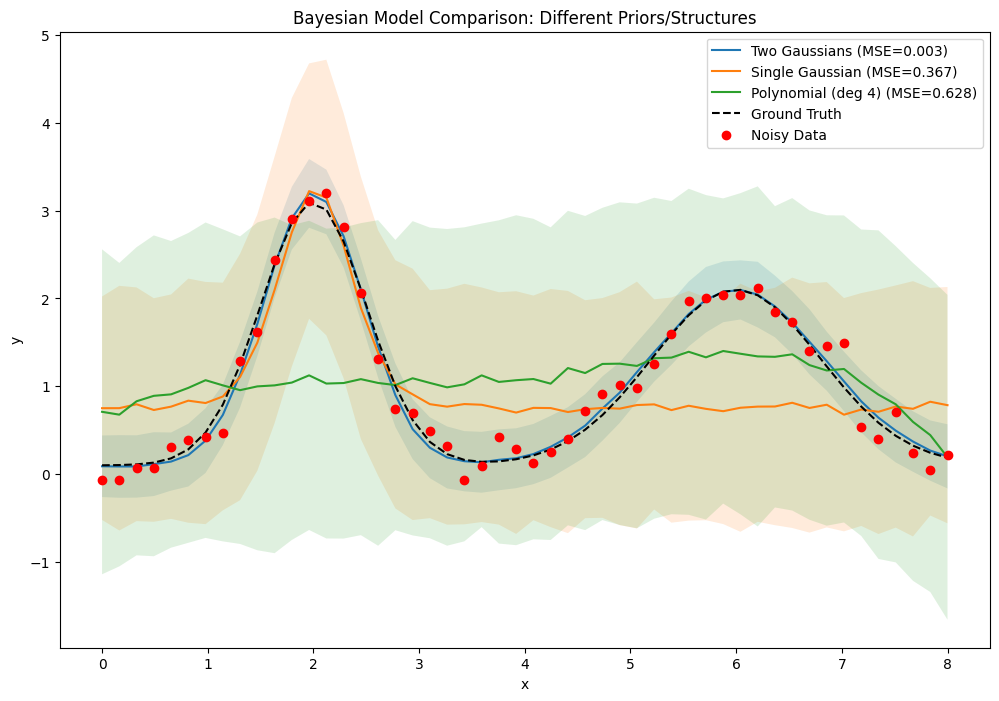

In [31]:
plt.figure(figsize=(12, 8))
for name, res in fit_results.items():
    plt.plot(x, res["mean"], label=f"{name} (MSE={res['mse']:.3f})")
    plt.fill_between(x, res["mean"]-2*res["std"], res["mean"]+2*res["std"], alpha=0.15)
plt.plot(x, y_true, 'k--', label="Ground Truth")
plt.scatter(x, y_obs, color='red', label="Noisy Data", zorder=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Bayesian Model Comparison: Different Priors/Structures")
plt.legend()
plt.show()

### Model Comparison Table

Summarize the performance of each model.

In [32]:
print(f"{'Model':<20} {'MSE':<10} {'Log-Likelihood':<15}")
print("-"*45)
for name, res in fit_results.items():
    print(f"{name:<20} {res['mse']:<10.4f} {res['loglik']:<15.2f}")

Model                MSE        Log-Likelihood 
---------------------------------------------
Two Gaussians        0.0030     14.21          
Single Gaussian      0.3673     -57.04         
Polynomial (deg 4)   0.6284     -66.16         


**Conclusion:**  
- The correct structure (Two Gaussians) should have the lowest MSE and highest log-likelihood.
- Underspecified or wrong structures (Single Gaussian, Polynomial) fit less well and have higher uncertainty.
- Bayesian inference allows principled model comparison using predictive performance and likelihood.